Loaded data shpae: (101766, 50)
Numeric features used: 13
Scaled feature matrix shape: (101766, 13)

SSD values (k, ssd):
 k=1: 1322958.00
 k=2: 1191604.30
 k=3: 1115777.83
 k=4: 1044743.27
 k=5: 985035.12
 k=6: 907884.33
 k=7: 904499.24
 k=8: 893930.90
 k=9: 832938.70
 k=10: 798277.38

Automatically detected elbow at k = 6


C:\Users\joshu\AppData\Local\Temp\ipykernel_30012\2148556907.py:46: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(p2 - p1, pt - p1)) / np.linalg.norm(p2 - p1)


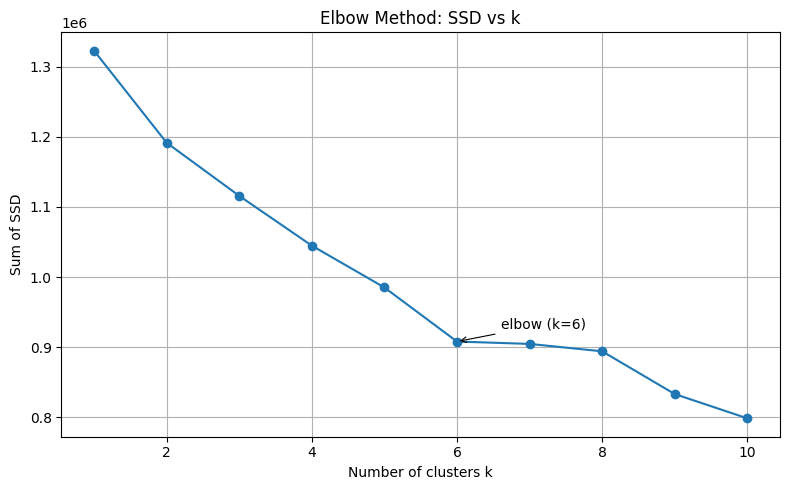


Centroids (original feature units) - showing first 10 columns if many:
           encounter_id   patient_nbr  admission_type_id  \
Cluster_0  1.951096e+08  6.314272e+07             1.5978   
Cluster_1  9.226211e+07  2.244912e+07             1.3214   
Cluster_2  1.707777e+08  5.722577e+07             2.9850   
Cluster_3  2.433080e+08  8.256161e+07             1.3114   
Cluster_4  9.268496e+07  4.535812e+07             5.4634   
Cluster_5  1.556914e+08  5.044834e+07             1.7185   

           discharge_disposition_id  admission_source_id  time_in_hospital  \
Cluster_0                    3.2745               6.1155            4.5395   
Cluster_1                    3.6656               5.9165            3.3906   
Cluster_2                    2.8486               1.6116            3.0436   
Cluster_3                    2.6548               6.1819            3.4693   
Cluster_4                    4.9495              14.6574            4.2949   
Cluster_5                    5.7120    

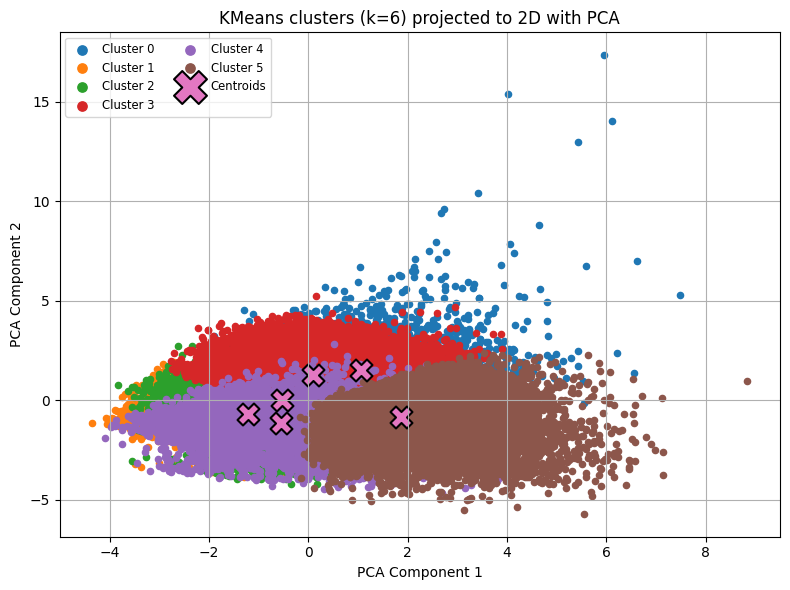

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df = pd.read_csv("C:\\Users\\joshu\\OneDrive\\Desktop\\python\\Intro to programming\\diabetic_data.csv")
print("Loaded data shpae:", df.shape)

numeric = df.select_dtypes(include=[np.number]).copy()
if numeric.shape[1] ==0:
    numeric = df.apply(pd.to_numeric, errors="coerce")
numeric = numeric.loc[:, numeric.nunique() > 1] #drops constant columns
numeric = numeric.fillna(numeric.median()) #impute missing values with median
print("Numeric features used:", numeric.shape[1])

#standardize features
scaler = StandardScaler()
X = scaler.fit_transform(numeric.values)
print("Scaled feature matrix shape:", X.shape)

#Compute SSD (inertia) for k = 1..10 using minibatchkmeans 
K = list(range(1, 11))
ssd = []
for k in K:
    if k ==1:
        #inertia for k=1 = sum squared distance to global mean
        global_mean = X.mean(axis=0)
        ssd.append(np.sum((X - global_mean) ** 2))
        continue
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, max_iter=200, n_init=5)
    mbk.fit(X)
    ssd.append(mbk.inertia_)

print("\nSSD values (k, ssd):")
for k_val, val in zip(K, ssd):
    print(f" k={k_val}: {val:.2f}")

#Automatic elbow detection using geometric method:
# draw line between (k_min, ssd_min) and (k_max, ssd_max) and pick k with maximum perpendicular
pts = np.column_stack((K, ssd))
p1 = pts[0]; p2 = pts[-1]
def perp_distance(pt, p1, p2):
    return np.abs(np.cross(p2 - p1, pt - p1)) / np.linalg.norm(p2 - p1)
dists = [perp_distance(pts[i], p1, p2) for i in range(len(pts))]
elbow_idx = int(np.argmax(dists[1:-1]) + 1) #ignore endpoints
optimal_k = K[elbow_idx]
print(f"\nAutomatically detected elbow at k = {optimal_k}")
# where the elbow is on the graph is the number of clusters we should include in our analysis. 

#plot elbow chart
plt.figure(figsize=(8, 5))
plt.plot(K, ssd, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of SSD")
plt.title("Elbow Method: SSD vs k")
plt.scatter([optimal_k], [ssd[elbow_idx]], s=150, facecolors='none', linewidths=2)
plt.annotate(f"elbow (k={optimal_k})", xy=(optimal_k, ssd[elbow_idx]),
             xytext=(optimal_k+0.6, ssd[elbow_idx]*1.02),
             arrowprops=dict(arrowstyle="->", linewidth=0.8))
plt.grid(True)
plt.tight_layout()
plt.show()

#Fit final KMeans with optimal_k
mbk_opt = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1024, max_iter=500, n_init=10)
labels = mbk_opt.fit_predict(X)
centroids = mbk_opt.cluster_centers_  #centroids in scaled space

#Inverse-transform centroids to original units 
centroids_orig = scaler.inverse_transform(centroids)
centroid_df = pd.DataFrame(centroids_orig, columns=numeric.columns)
centroid_df.index = [f"Cluster_{i}" for i in range(centroid_df.shape[0])]
print("\nCentroids (original feature units) - showing first 10 columns if many:")
print(centroid_df.iloc[:, :min(10, centroid_df.shape[1])].round(4))

#cluster sizes
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes.to_string())

#Visualize clusters in 2D using PCA
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)
centroids_2 = pca.transform(centroids)

plt.figure(figsize=(8,6))
for lab in np.unique(labels):
    mask = labels == lab
    plt.scatter(X2[mask, 0], X2[mask, 1], s=20, label=f"Cluster {lab}")
plt.scatter(centroids_2[:, 0], centroids_2[:, 1], s=250, marker='X', edgecolors='k', linewidths=1.5, label='Centroids')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"KMeans clusters (k={optimal_k}) projected to 2D with PCA")
plt.legend(markerscale=1.5, fontsize= 'small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
#I chose to do 2D to make it easier to read and analyze. Due to this, some of the centroids look like they belong to the same cluster, but they do not. 
